# Experiment2
## k-fold trainning to get optimal model and output avg and std of scores

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import Dina
from Dina import McmcHoDina
from Dina import MlDina
import pandas as pd
from utils import r4beta
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import progressbar
import collections
import random
from transformer import MyDataSet, Transformer

In [4]:
def load_data(path, ratio):
    full_data = pd.read_csv(path + 'data.txt', header=None, sep='\t').values
    q_matrix = pd.read_csv(path + 'q.txt', header=None, sep='\t').values
    num_samples, num_items, num_skills = full_data.shape[0], full_data.shape[1], q_matrix.shape[1]
    
    train_data = full_data[ : int(num_samples * ratio)]
    train_data = binary_classify(train_data)
    test_data = full_data[int(num_samples * ratio): ]
    test_data = binary_classify(test_data)
    
    return train_data, test_data, q_matrix, num_samples, num_items, num_skills

def binary_classify(data):
    data[data <= 0.5] = 0
    data[data > 0.5] = 1
    return data.astype(np.int64)

def get_scores(true_scores, pred_scores):

    fpr, tpr, thresholds = metrics.roc_curve(true_scores, pred_scores)
    # accuracy, precision, recall, f1
    pred_scores = binary_classify(pred_scores)
    accuracy = accuracy_score(true_scores, pred_scores)
    precision = precision_score(true_scores, pred_scores)
    recall = recall_score(true_scores, pred_scores)
    f1 = f1_score(true_scores, pred_scores)
    
    roc_auc = roc_auc_score(true_scores, pred_scores)

    return accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc

def get_prior_skills(x, y, q_matrix):
    guess = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    slip = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    max_iter = 100
    tol = 1e-5
    EmDina = Dina.EmDina(guess, slip, max_iter, tol, q_matrix, x)
    est_s, est_g = EmDina.em()
    dina_est = Dina.MlDina(est_g, est_s, q_matrix, y)
    est_skills = dina_est.get_skills_by_Ml()
    return est_skills

def create_dict():
    d = collections.OrderedDict()
    
    model1 = collections.OrderedDict()
    model1['accuracy_his'], model1['precision_his'], model1['recall_his'], model1['f1_his'], model1['roc_auc_his'], model1['fpr_his'], model1['tpr_his'] = [], [], [], [], [], [], []
    
    model2 = collections.OrderedDict()
    model2['accuracy_his'], model2['precision_his'], model2['recall_his'], model2['f1_his'], model2['roc_auc_his'], model2['fpr_his'], model2['tpr_his'] = [], [], [], [], [], [], []
    
    model3 = collections.OrderedDict()
    model3['accuracy_his'], model3['precision_his'], model3['recall_his'], model3['f1_his'], model3['roc_auc_his'], model3['fpr_his'], model3['tpr_his'] = [], [], [], [], [], [], []
    
    d['FrcSub'] = model1
    d['Math1'] = model2
    d['Math2'] = model3
    return d

In [5]:
results = create_dict()

In [6]:
def train_cross_valid(dataset):
    
    train_data, test_data, q_matrix, num_samples, num_items, num_skills = load_data('./'+ dataset + '/', 0.8)
    x_train, y_train, x_test, y_test = train_data, train_data, test_data, test_data
    batch_size = int(num_samples / 50)
    epoch_size = 50
    src_len = num_items # enc_input max sequence length
    tgt_len = num_items # dec_input(=dec_output) max sequence length
    
    accuracy_his, precision_his, recall_his, f1_his, fpr_his, tpr_his, roc_auc_his = [], [], [], [], [], [], []
    #results = create_dict()
    
    kf = KFold(n_splits=10, shuffle=False)
    fold = 1
    for train_index, valid_index in kf.split(train_data):
        #print("Train: ", train_index.shape, "Validation: ", valid_index.shape)
        x_train, x_valid = train_data[train_index], train_data[valid_index]
        y_train, y_valid = train_data[train_index], train_data[valid_index]
    
        est_skills_train = get_prior_skills(x_train, y_train, q_matrix)
        enc_inputs_train = torch.LongTensor(x_train)
        dec_inputs_train = torch.LongTensor(est_skills_train)
        dec_outputs_train = torch.FloatTensor(y_train)

        est_skills_valid = get_prior_skills(x_valid, y_valid, q_matrix)
        enc_inputs_valid = torch.LongTensor(x_valid)
        dec_inputs_valid = torch.LongTensor(est_skills_valid)
        dec_outputs_valid = torch.FloatTensor(y_valid)

        loader = Data.DataLoader(MyDataSet(enc_inputs_train, dec_inputs_train, dec_outputs_train), batch_size, True)
        model = Transformer(num_items, num_skills, d_model=32, d_ff=16, d_k=8, d_v=8, n_layers=3, n_heads=8, batch_size=batch_size)
        loss_func = nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=1e-3)
        optimizer =optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    
        
        max_auc = 0
        for epoch in range(epoch_size):

            for enc_inputs_batch, dec_inputs_batch, dec_outputs_batch in loader:

                outputs_batch, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs_batch, dec_inputs_batch)

                #print(outputs.shape, dec_outputs.shape) # outputs[400, 20]: 400 = 50(batch_size) * 8(tgt_len), 20(tgt_vocab_size) # dec_outputs[50, 8]: [batch_size, tgt_len]
                #break
                loss = loss_func(outputs_batch, dec_outputs_batch)
                #if (epoch + 1) == 100:
                #    loss_his.append(loss.data.item())
                #print(loss.dtype)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            #if (epoch + 1) % 10 == 0:
            #    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))


            # get RMSE on valid dataset:
            with torch.no_grad():
                outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs_valid, dec_inputs_valid)
                predict = outputs.detach().numpy()
                pred = predict.reshape(-1)
                true = y_valid.reshape(-1)
                true = binary_classify(true)
            accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
            if roc_auc > max_auc:
                max_auc = roc_auc
                torch.save(model.state_dict(), './Results/Transformer_state_dict_Experiment2_' + dataset + '.pt')
        
        #test error on test dataset
        with torch.no_grad():
            transformer = Transformer(num_items, num_skills, d_model=32, d_ff=16, d_k=8, d_v=8, n_layers=3, n_heads=8, batch_size=batch_size)
            transformer.load_state_dict(torch.load('./Results/Transformer_state_dict_Experiment2_' + dataset + '.pt'))
            outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs_valid, dec_inputs_valid)
            predict = outputs.detach().numpy()
            pred = predict.reshape(-1)
            true = y_valid.reshape(-1)
            true = binary_classify(true)
            
        accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
        accuracy_his.append(accuracy)
        precision_his.append(precision)
        recall_his.append(recall)
        f1_his.append(f1)
        roc_auc_his.append(roc_auc)
        fpr_his.append(fpr)
        tpr_his.append(tpr)
            
        results[dataset]['accuracy_his'].append(accuracy)
        results[dataset]['precision_his'].append(precision)
        results[dataset]['recall_his'].append(recall)
        results[dataset]['f1_his'].append(f1)
        results[dataset]['roc_auc_his'].append(roc_auc)
        results[dataset]['fpr_his'].append(fpr)
        results[dataset]['tpr_his'].append(tpr)   
        
        
        print("============================================Fold{}============================================".format(fold))
        print("Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))
        
        
        fold = fold + 1
    #torch.save(model.state_dict(), './Results/Transformer_state_dict_Experiment2' + dataset + '.pt')
    torch.save(results, './Results/data/scores_Experiment2_' + dataset + '.pt')
    
    return accuracy_his, precision_his, recall_his, f1_his, fpr_his, tpr_his, roc_auc_his

In [7]:
print("> Training on FrcSub Dataset...")
accuracy_his1, precision_his1, recall_his1, f1_his1, fpr_his1, tpr_his1, roc_auc_his1 = train_cross_valid('FrcSub')
print("> Training on Math1 Dataset...")
accuracy_his2, precision_his2, recall_his2, f1_his2, fpr_his2, tpr_his2, roc_auc_his2 = train_cross_valid('Math1')
print("> Training on Math2 Dataset...")
accuracy_his3, precision_his3, recall_his3, f1_his3, fpr_his3, tpr_his3, roc_auc_his3 = train_cross_valid('Math2')

> Training on FrcSub Dataset...
============================================Fold1============================================
Accuracy: 0.893023 | Precision: 0.879518 | Recall: 0.896806 | F1: 0.888078 | AUC: 0.893215
============================================Fold2============================================
Accuracy: 0.891860 | Precision: 0.841975 | Recall: 0.921622 | F1: 0.880000 | AUC: 0.895505
============================================Fold3============================================
Accuracy: 0.900000 | Precision: 0.901923 | Recall: 0.930556 | F1: 0.916016 | AUC: 0.893649
============================================Fold4============================================
Accuracy: 0.896512 | Precision: 0.900735 | Recall: 0.933333 | F1: 0.916745 | AUC: 0.886070
============================================Fold5============================================
Accuracy: 0.863953 | Precision: 0.955769 | Recall: 0.840948 | F1: 0.894689 | AUC: 0.877723
===========================================

In [14]:
results_Faverageb = torch.load('./Results/data/scores_Experiment2_' + 'FrcSub' + '.pt')
results_Math1 = torch.load('./Results/data/scores_Experiment2_' + 'Math1' + '.pt')
results_Math2 = torch.load('./Results/data/scores_Experiment2_' + 'Math2' + '.pt')

In [9]:
print(results_FrcSub['FrcSub']['roc_auc_his'])

[0.8932153104338534, 0.8955046883618313, 0.8936485642946318, 0.8860696517412935, 0.8777228438976217, 0.8799330212733569, 0.8786053199137311, 0.8705962059620597, 0.8583438013334621, 0.9081289081289083]


In [15]:
print('FrcSub mean: ', np.average(results_FrcSub['FrcSub']['precision_his']), np.average(results_FrcSub['FrcSub']['recall_his']), np.average(results_FrcSub['FrcSub']['f1_his']), np.average(results_FrcSub['FrcSub']['roc_auc_his']))
print('FrcSub std: ', np.std(results_FrcSub['FrcSub']['precision_his']), np.std(results_FrcSub['FrcSub']['recall_his']), np.std(results_FrcSub['FrcSub']['f1_his']), np.std(results_FrcSub['FrcSub']['roc_auc_his']))

print('Math1  mean: ', np.average(results_Math1['Math1']['precision_his']), np.average(results_Math1['Math1']['recall_his']), np.average(results_Math1['Math1']['f1_his']), np.average(results_Math1['Math1']['roc_auc_his']))
print('Math1  std: ', np.std(results_Math1['Math1']['precision_his']), np.std(results_Math1['Math1']['recall_his']), np.std(results_Math1['Math1']['f1_his']), np.std(results_Math1['Math1']['roc_auc_his']))

print('Math2  mean: ', np.average(results_Math2['Math2']['precision_his']), np.average(results_Math2['Math2']['recall_his']), np.average(results_Math2['Math2']['f1_his']), np.average(results_Math2['Math2']['roc_auc_his']))
print('Math2  std: ', np.std(results_Math2['Math2']['precision_his']), np.std(results_Math2['Math2']['recall_his']), np.std(results_Math2['Math2']['f1_his']), np.std(results_Math2['Math2']['roc_auc_his']))


FrcSub mean:  0.8962465930239171 0.8938414082053467 0.8937487535083827 0.8841768315340749
FrcSub std:  0.031563053087118015 0.0422505314152992 0.01684780322293694 0.01348887455687114
Math1  mean:  0.8063865121549718 0.7653171603458462 0.7830665625685537 0.7970905418463147
Math1  std:  0.043692650099137455 0.04573559572947463 0.016357286895647884 0.015376765104135787
Math2  mean:  0.8140140371451636 0.8112503158845428 0.8116343006677488 0.8326768138375724
Math2  std:  0.027474714021111818 0.03789739251520543 0.019048201865032692 0.01956637088303254


In [27]:
def draw_scores(dataset, accuracy_his, precision_his, recall_his, f1_his, roc_auc_his):
    xrange = np.arange(0,len(accuracy_his))
    plt.grid(b=True, color='gray', linestyle='--', linewidth=1, alpha=0.3) 
    plt.xlim(0, 50)
    plt.ylim(0.5, 1.0)
    plt.xlabel('Epoch')
    plt.ylabel('Scores')
    plt.title(dataset)
    #plt.plot(fpr_list[0], tpr_list[0], color='darkorange', lw=2, label='Frbsub (area = %0.3f)' % roc_auc_list[0])
    plt.plot(xrange, accuracy_his, color='r', linestyle='-', label='Rmse')
    plt.plot(xrange, precision_his, color='g', linestyle='--', label='Precision')
    plt.plot(xrange, recall_his, color='orange', linestyle='-.', label='Recall')
    plt.plot(xrange, f1_his, color='b', linestyle=':', label='F1')
    plt.plot(xrange, roc_auc_his, linestyle='-', color='purple', label='AUC')
    plt.legend(loc="lower right")
    plt.savefig('./Results/scores_' + dataset + '.png')

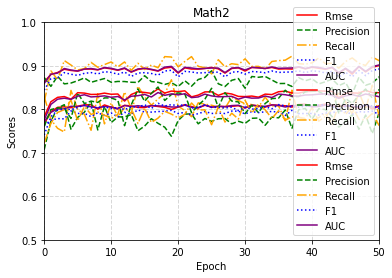

In [28]:
draw_scores('FrcSub', accuracy_his1, precision_his1, recall_his1, f1_his1, roc_auc_his1)
draw_scores('Math1', accuracy_his2, precision_his2, recall_his2, f1_his2, roc_auc_his2)
draw_scores('Math2', accuracy_his3, precision_his3, recall_his3, f1_his3, roc_auc_his3)

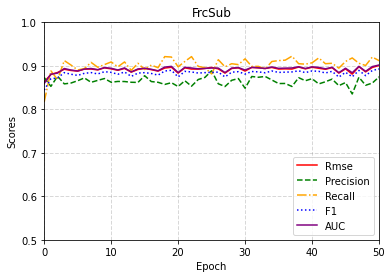

In [29]:
draw_scores('FrcSub', accuracy_his1, precision_his1, recall_his1, f1_his1, roc_auc_his1)

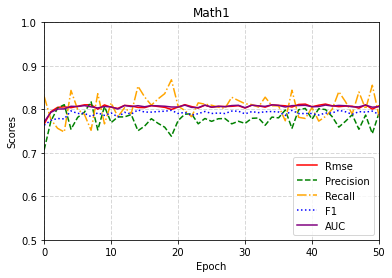

In [30]:
draw_scores('Math1', accuracy_his2, precision_his2, recall_his2, f1_his2, roc_auc_his2)

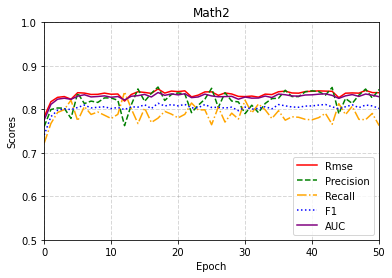

In [31]:
draw_scores('Math2', accuracy_his3, precision_his3, recall_his3, f1_his3, roc_auc_his3)

In [32]:
accuracy_his1, accuracy_his2, accuracy_his3 = np.array(accuracy_his1), np.array(accuracy_his2), np.array(accuracy_his3)
precision_his1, precision_his2, precision_his3 = np.array(precision_his1), np.array(precision_his2), np.array(precision_his3)
recall_his1, recall_his2, recall_his3 = np.array(recall_his1), np.array(recall_his2), np.array(recall_his3)
f1_his1, f1_his2, f1_his3 = np.array(f1_his1), np.array(f1_his2), np.array(f1_his3)
roc_auc_his1, roc_auc_his2, roc_auc_his3 = np.array(roc_auc_his1), np.array(roc_auc_his2), np.array(roc_auc_his3)

In [33]:
accurcy_his_Experiment1 = np.array([accuracy_his1, accuracy_his2, accuracy_his3])
precision_his_Experiment1 = np.array([precision_his1, precision_his2, precision_his3])
recall_his_Experiment1 = np.array([recall_his1, recall_his2, recall_his3])
f1_his_Experiment1 = np.array([f1_his1, f1_his2, f1_his3])
roc_auc_his_Experiment1 = np.array([roc_auc_his1, roc_auc_his2, roc_auc_his3])
np.save('./Results/data/accurcy_his_Experiment1.npy', accurcy_his_Experiment1)
np.save('./Results/data/precision_his_Experiment1.npy', precision_his_Experiment1)
np.save('./Results/data/recall_his_Experiment1.npy', recall_his_Experiment1)
np.save('./Results/data/f1_his_Experiment1.npy', f1_his_Experiment1)
np.save('./Results/data/roc_auc_his_Experiment1.npy', roc_auc_his_Experiment1)

In [34]:
roc_auc_his_ = np.load('./Results/data/roc_auc_his_Experiment1.npy')
#print(roc_auc_his_.shape)